In [43]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

import butterflies
from dwt_transform import DWT2Numpy
from network import Net, run

device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
import matplotlib.pyplot as plt

def get_epoch_info_from_file(file):
    epochs = []
    accuracies = []
    test_losses = []
    with open(file, "r") as f:
        for line in f.readlines():
            line = line.lower()
            if "epoch" in line:
                _, epoch_num = line.split()
                epochs.append(epoch_num)
            if "accuracy" in line:
                _, accuracy_raw, _, _, loss_raw = line.split()
                accuracy = float(accuracy_raw.strip("%,"))
                loss_val = float(loss_raw)
                accuracies.append(accuracy)
                test_losses.append(loss_val)
    return epochs, (accuracies, test_losses)
                
def _get_fig_ax(fig=None, ax=None):
    if fig is None:
        fig = plt.figure()
        ax = fig.gca()
    if ax is None:
        ax = fig.gca()
    return fig, ax

def plot_file(file, label, fig=None, ax=None):
    fig, ax = _get_fig_ax(fig, ax)
    epochs, (accuracy, _) = get_epoch_info_from_file(file)
    ax.plot(epochs, accuracy, label=label)
    return fig, ax

def plot_epoch_info(original_file, wav_files, dataset_str, wav_strs):
    fig, ax = plot_file(original_file, dataset_str)
    for wav_label, file in zip(wav_strs, wav_files):
        plot_file(file, dataset_str + ": " + wav_label, fig=fig, ax=ax)
    fig.legend(loc="center right")
    return fig, ax

In [45]:
transform_dwt = transforms.Compose([DWT2Numpy("haar"), transforms.ToTensor()])

train_data_dwt = butterflies.ButterflyDataset("../data", datasplit="train", transform=transform_dwt)
val_data_dwt = butterflies.ButterflyDataset("../data", datasplit="valid", transform=transform_dwt)
test_data_dwt = butterflies.ButterflyDataset("../data", datasplit="test", transform=transform_dwt)

batch_size = 64
train_loader_dwt = DataLoader(
    train_data_dwt, batch_size=batch_size, shuffle=True, num_workers=4#, pin_memory=True
)
val_loader_dwt = DataLoader(
    val_data_dwt, batch_size=batch_size, shuffle=False, num_workers=2#, pin_memory=True
)
test_loader_dwt = DataLoader(
    test_data_dwt, batch_size=batch_size, shuffle=False, num_workers=2#, pin_memory=True
)


In [46]:
transform = transforms.ToTensor()

train_data = butterflies.ButterflyDataset("../data", datasplit="train", transform=transform)
val_data = butterflies.ButterflyDataset("../data", datasplit="valid", transform=transform)
test_data = butterflies.ButterflyDataset("../data", datasplit="test", transform=transform)

batch_size = 64
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

In [47]:
loss_fn = torch.nn.NLLLoss()

In [48]:
net = Net(
    conv_layers=((12, 5), (32, 5), (64, 5)),
    linear_layers=(512, 256),
    output_size=len(train_data.classes),
    output_activation=lambda x: torch.log_softmax(x, dim=1),
)
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, dampening=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [49]:
net_dwt = Net(
    conv_layers=((32, 5), (64, 5), (128, 3)),
    linear_layers=(512, 256),
    output_size=len(train_data.classes),
    output_activation=lambda x: torch.log_softmax(x, dim=1),
)
# net_dwt = Net(
#     conv_layers=(),
#     linear_layers=(1024,),
#     output_size=len(train_data.classes),
#     output_activation=torch.sigmoid,
# )
net_dwt.to(device)
# optimizer_dwt = optim.SGD(net_dwt.parameters(), lr=0.01, momentum=0.9, dampening=0.1)
optimizer_dwt = optim.Adam(net_dwt.parameters(), lr=0.001)

In [50]:
%%capture out_normal
run(train_loader, val_loader, net, loss_fn, optimizer, device, 100)

In [51]:
out_normal()
%store out_normal.stdout >../result/Butterfly_original.txt

Epoch 1
-------------------------------
loss: 4.605122  [    0/12639]
loss: 4.614729  [ 1216/12639]
loss: 4.464983  [ 2432/12639]
loss: 4.200217  [ 3648/12639]
loss: 4.337713  [ 4864/12639]
loss: 4.069219  [ 6080/12639]
loss: 3.866331  [ 7296/12639]
loss: 4.001525  [ 8512/12639]
loss: 3.844180  [ 9728/12639]
loss: 3.845506  [10944/12639]
loss: 3.690720  [12160/12639]
Test Error: 
 Accuracy: 8.8%, Avg loss: 3.790590 

Epoch 2
-------------------------------
loss: 3.775268  [    0/12639]
loss: 3.483095  [ 1216/12639]
loss: 3.726723  [ 2432/12639]
loss: 3.713195  [ 3648/12639]
loss: 3.193087  [ 4864/12639]
loss: 3.484811  [ 6080/12639]
loss: 3.086228  [ 7296/12639]
loss: 3.273263  [ 8512/12639]
loss: 2.961895  [ 9728/12639]
loss: 2.909862  [10944/12639]
loss: 2.772130  [12160/12639]
Test Error: 
 Accuracy: 30.6%, Avg loss: 2.753097 

Epoch 3
-------------------------------
loss: 2.614902  [    0/12639]
loss: 2.598950  [ 1216/12639]
loss: 2.449015  [ 2432/12639]
loss: 2.672520  [ 3648/1263

In [52]:
%%capture out_dwt
run(train_loader_dwt, val_loader_dwt, net_dwt, loss_fn, optimizer_dwt, device, 100)

In [53]:
out_dwt()
%store out_dwt.stdout >../result/Butterfly_haar.txt

Epoch 1
-------------------------------
loss: 5.246373  [    0/12639]
loss: 4.559326  [ 1216/12639]
loss: 4.407759  [ 2432/12639]
loss: 4.314204  [ 3648/12639]
loss: 4.274246  [ 4864/12639]
loss: 4.156268  [ 6080/12639]
loss: 3.893214  [ 7296/12639]
loss: 3.828947  [ 8512/12639]
loss: 3.774927  [ 9728/12639]
loss: 3.392907  [10944/12639]
loss: 3.372861  [12160/12639]
Test Error: 
 Accuracy: 19.6%, Avg loss: 3.420598 

Epoch 2
-------------------------------
loss: 3.124440  [    0/12639]
loss: 3.310673  [ 1216/12639]
loss: 2.878353  [ 2432/12639]
loss: 3.176031  [ 3648/12639]
loss: 2.941047  [ 4864/12639]
loss: 3.109263  [ 6080/12639]
loss: 2.661655  [ 7296/12639]
loss: 3.033356  [ 8512/12639]
loss: 3.037754  [ 9728/12639]
loss: 2.701723  [10944/12639]
loss: 2.653114  [12160/12639]
Test Error: 
 Accuracy: 40.0%, Avg loss: 2.503651 

Epoch 3
-------------------------------
loss: 2.232703  [    0/12639]
loss: 2.366620  [ 1216/12639]
loss: 2.056319  [ 2432/12639]
loss: 2.708824  [ 3648/126

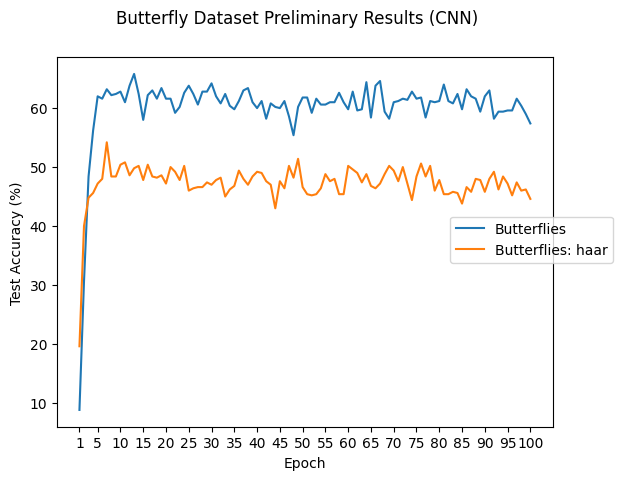

In [54]:
fig, ax = plot_epoch_info("../result/Butterfly_original.txt", ["../result/Butterfly_haar.txt"], "Butterflies", ["haar"])
ax.set_xticks([0] + [5*i - 1 for i in range(1, 21)])
ax.set_ylabel("Test Accuracy (%)")
ax.set_xlabel("Epoch")
fig.suptitle("Butterfly Dataset Preliminary Results (CNN)")
plt.show()

In [55]:
%store out_dwt.stdout >../result/Butterfly_haar.txt

Writing 'out_dwt.stdout' (str) to file '../result/Butterfly_haar.txt'.


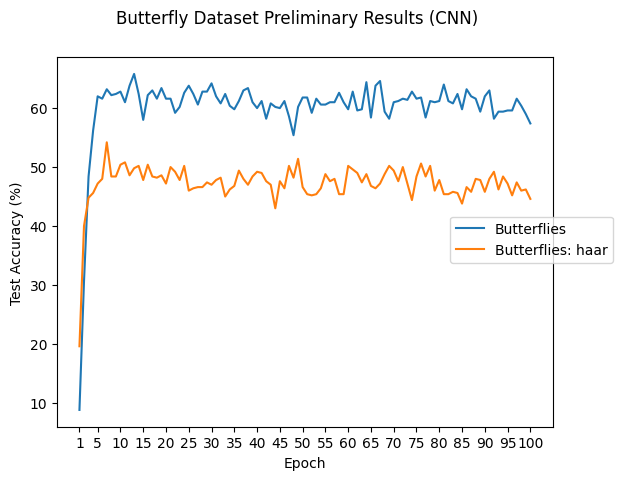

In [54]:
fig, ax = plot_epoch_info("../result/Butterfly_original.txt", ["../result/Butterfly_haar.txt"], "Butterflies", ["haar"])
ax.set_xticks([0] + [5*i - 1 for i in range(1, 21)])
ax.set_ylabel("Test Accuracy (%)")
ax.set_xlabel("Epoch")
fig.suptitle("Butterfly Dataset Preliminary Results (CNN)")
plt.show()